In [1]:
from transformers import AutoFeatureExtractor, CvtForImageClassification
from torch.utils.data import Dataset, DataLoader
from string import digits
from html import unescape
from sklearn.model_selection import train_test_split
from torchmetrics.functional.classification import auroc, accuracy

import torchvision
import torch
import torch.nn as nn
import pandas as pd
import os
import pytorch_lightning as pl
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('medium')

In [14]:
os.chdir(r'C:\Users\rabby\CS 7643 - Deep Learning\Project')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = {
    'model_name': 'microsoft/cvt-21',
    'n_labels': 14,
    'batch_size': 32,
    'dropout': 0.325,
    'hidden_size': 128,
    'lr': 7e-6,
    'n_epochs': 10,
    'device': device,
    'n_img_train': 10000,
    'n_img_val': 1,
    'img_train': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\train',
    'img_val': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\val',
    'label_train':r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\fairface_label_train.csv',
    'label_val': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\fairface_label_val.csv',
    'img_train_path': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval',
    'reload': False,
    'img_train_rl': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\img_train_1_8.pt',
    'img_val_rl': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\img_val20.pt',
    'label_train_rl': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\labels_train_1_8.csv',
    'label_val_rl': r'C:\Users\rabby\CS 7643 - Deep Learning\Project\Data\fairface-img-margin025-trainval\labels_val20.csv'
}
config['img_train_list'] = [config['img_train_path'] + '\\' + 'img_train_' + str(i) + '_8.pt' for i in range(1, 9)]
config['label_train_list'] = [config['img_train_path'] + '\\' + 'labels_train_' + str(i) + '_8.csv' for i in range(1, 9)]

In [3]:
def Load_Images(config):
    
    #Load Train Data
    extractor = AutoFeatureExtractor.from_pretrained(config['model_name'])
    i = 0
    file_train = []
    for dir_name, _, file_list in os.walk(config['img_train']):
        for file in file_list:
            if file:
                img_name = os.path.join(dir_name, file)
                if i == 0:
                    img_train = torchvision.io.read_image(img_name)
                    print('Training Image', str(i), 'loaded.')
                else:
                    img_train = torch.cat((img_train.view(i, 3, 224, 224), torchvision.io.read_image(img_name).view(1, 3, 224, 224)))
                img_name_split = img_name.split('\\')
                img_name_short = '/'.join(img_name_split[-2:])
                file_train.append(img_name_short)
                i += 1
                if(i % 1000 == 0):
                    print('Training Image', str(i), 'loaded.')
            if i == config['n_img_train']:
                break
                
    img_train = extractor(img_train, return_tensors="pt")['pixel_values']
    
    print(str(i), 'Training images loaded.')
    labels_train_full = pd.read_csv(config['label_train'], index_col = 'file')
    labels_train = labels_train_full.loc[file_train, ['gender', 'race']]
    labels_train['label'] = pd.Categorical(labels_train['gender'] + '_' + labels_train['race'])
    labels_train['label'] = labels_train['label'].cat.codes
    print('---------------------------------')
    #Load Val Data
    i = 0
    file_val = []
    for dir_name, _, file_list in os.walk(config['img_val']):
        for file in file_list:
            if file:
                img_name = os.path.join(dir_name, file)
                if i == 0:
                    img_val = torchvision.io.read_image(img_name)
                    print('Validation Image', str(i), 'loaded.')
                else:
                    img_val = torch.cat((img_val.view(i, 3, 224, 224), torchvision.io.read_image(img_name).view(1, 3, 224, 224)))
                img_name_split = img_name.split('\\')
                img_name_short = '/'.join(img_name_split[-2:])
                file_val.append(img_name_short)
                i += 1
                if(i % 1000 == 0):
                    print('Validation Image', str(i), 'loaded.')
            if i == config['n_img_val']:
                break
                
    img_val = extractor(img_val, return_tensors="pt")['pixel_values']
    
    print(str(i), 'Validation images loaded.')  
    labels_val_full = pd.read_csv(config['label_val'], index_col = 'file')
    labels_val = labels_val_full.loc[file_val, ['gender', 'race']]
    labels_val['label'] = pd.Categorical(labels_val['gender'] + '_' + labels_val['race'])
    labels_val['label'] = labels_val['label'].cat.codes
    
    return img_train, labels_train, img_val, labels_val

In [4]:
def Load_Img_Train(config, k):
    
    for i in range(k):
        if i == 0:
            img_train = torch.load(config['img_train_list'][i])
            labels_train = pd.read_csv(config['label_train_list'][i])
            print(i + 1)
        else:
            img_train = torch.cat((img_train, torch.load(config['img_train_list'][i])))
            labels_train = pd.concat((labels_train, pd.read_csv(config['label_train_list'][i]))).reset_index(drop = True)
            print(i + 1)
    return img_train, labels_train

In [5]:
class Images_Dataset(Dataset):
    
    def __init__(self, data, label):
        #Declare variables
        self.data = data
        self.label = torch.tensor(label['label'])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]
    
class Images_Data_Module(pl.LightningDataModule):
    
    def __init__(self, train_data, train_label, val_data, val_label, batch_size = 16):
        super().__init__()
        self.train_data = train_data
        self.train_label = train_label
        self.val_data = val_data
        self.val_label = val_label
        self.batch_size = batch_size
        
    def setup(self, stage = None):
        self.train_ds = Images_Dataset(self.train_data, self.train_label)
        self.val_ds = Images_Dataset(self.val_data, self.val_label)
        self.test_ds = Images_Dataset(self.val_data, self.val_label)
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size = self.batch_size, shuffle = True)
    
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size = self.batch_size, shuffle = False)
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size = self.batch_size, shuffle = False)

In [6]:
class CVT_Fairface(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(config['model_name'])
        self.model = CvtForImageClassification.from_pretrained(config['model_name']).to(device)
        self.new_classifier = nn.Linear(384, self.config['n_labels']).to(device)
        torch.nn.init.xavier_uniform_(self.new_classifier.weight)
        self.model.classifier = self.new_classifier
        self.softmax = nn.Softmax(dim = 1)
        self.loss = nn.CrossEntropyLoss()
        self.training_step_outputs = []
        self.training_auroc = []
        self.training_acc = []
        self.validation_step_outputs = []
        self.validation_auroc = []
        self.validation_acc = []
        self.test_step_outputs = []
        self.test_auroc = []
        self.test_acc = []
        self.tloss = []
        self.tauroc = []
        self.tacc = []
        self.vloss = []
        self.vauroc = []
        self.vacc = []
           
    def forward(self, x, labels = None):
        features = x.to(self.config['device'])
        out = self.model(features)
        return out.logits
    
    def training_step(self, batch, batch_index):
        loss, out, y = self._common_step(batch, batch_index)
        pred = self.softmax(out)
        t_auroc = auroc(pred, y, task = 'multiclass', num_classes = self.config['n_labels'])
        t_acc = accuracy(pred, y, task = 'multiclass', num_classes = self.config['n_labels'])
        self.training_step_outputs.append(loss)
        self.training_auroc.append(t_auroc)
        self.training_acc.append(t_acc)
        self.log("Training Accuracy", t_acc, prog_bar = True, logger = True)
        return loss
    
    def on_train_epoch_end(self):
        epoch_mean = torch.stack(self.training_step_outputs).mean()
        epoch_auroc = torch.stack(self.training_auroc).mean()
        epoch_acc = torch.stack(self.training_acc).mean()
        self.tloss.append(float(epoch_mean.detach().cpu().numpy()))
        self.tauroc.append(float(epoch_auroc.detach().cpu().numpy()))
        self.tacc.append(float(epoch_acc.detach().cpu().numpy()))
        self.training_step_outputs.clear()
        self.training_auroc.clear()
        self.training_acc.clear()
    
    def validation_step(self, batch, batch_index):
        loss, out, y = self._common_step(batch, batch_index)
        pred = self.softmax(out)
        v_auroc = auroc(pred, y, task = 'multiclass', num_classes = self.config['n_labels'])
        v_acc = accuracy(pred, y, task = 'multiclass', num_classes = self.config['n_labels'])
        self.validation_step_outputs.append(loss)
        self.validation_auroc.append(v_auroc)
        self.validation_acc.append(v_acc)
        self.log("Validation Accuracy", v_acc, prog_bar = True, logger = True)
        return loss
    
    def on_validation_epoch_end(self):
        epoch_mean = torch.stack(self.validation_step_outputs).mean()
        epoch_auroc = torch.stack(self.validation_auroc).mean()
        epoch_acc = torch.stack(self.validation_acc).mean()
        self.vloss.append(float(epoch_mean.detach().cpu().numpy()))
        self.vauroc.append(float(epoch_auroc.detach().cpu().numpy()))
        self.vacc.append(float(epoch_acc.detach().cpu().numpy()))
        self.validation_step_outputs.clear()
        self.validation_auroc.clear()
        self.validation_acc.clear()
    
    def test_step(self, batch, batch_index):
        loss, out, y = self._common_step(batch, batch_index)
        pred = self.softmax(out)
        t_auroc = auroc(pred, y, task = 'multiclass', num_classes = self.config['n_labels'])
        t_acc = accuracy(pred, y, task = 'multiclass', num_classes = self.config['n_labels'])
        self.test_step_outputs.append(loss)
        self.test_auroc.append(t_auroc)
        self.test_acc.append(t_acc)
        self.log("Test Accuracy", t_acc, prog_bar = True, logger = True)
        return loss

    def predict_step(self, batch, batch_index):
        loss, out, y = self._common_step(batch, batch_index)
        return loss
    
    def _common_step(self, batch, batch_index):
        x, y = batch
        x = x.type(torch.cuda.FloatTensor)
        y = y.type(torch.LongTensor)
        y = y.to(config['device'])
        out = self.forward(x)
        loss = self.loss(out, y)
        return loss, out, y
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = self.config['lr'])
        return [optimizer]
    
    def plot_loss(self):
        self.vloss.pop()
        plt.plot(self.tloss, label = 'Training')
        plt.plot(self.vloss, label = 'Validation')
        plt.title('Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def plot_auroc(self):
        self.vauroc.pop()
        plt.plot(self.tauroc, label = 'Training')
        plt.plot(self.vauroc, label = 'Validation')
        plt.title('AUROC')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def plot_accuracy(self):
        self.vacc.pop()
        plt.plot(self.tacc, label = 'Training')
        plt.plot(self.vacc, label = 'Validation')
        plt.title('Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [7]:
# datamodule
if config['reload'] == True:
    raw_img = Load_Images(config)
    img_data_module = Images_Data_Module(*raw_img, batch_size = config['batch_size'])
else:
    #train_data = torch.load(config['img_train_rl'])
    #train_label = pd.read_csv(config['label_train_rl'])
    train_data, train_label = Load_Img_Train(config, 8)
    val_data = torch.load(config['img_val_rl'])
    val_label = pd.read_csv(config['label_val_rl'])
    img_data_module = Images_Data_Module(train_data, train_label, val_data, val_label, batch_size = config['batch_size'])

1
2
3
4
5
6
7
8


In [ ]:
# model
model = CVT_Fairface(config)

# trainer and fit
trainer = pl.Trainer(max_epochs = config['n_epochs'], devices = 1, accelerator = "gpu", num_sanity_val_steps = 0)
trainer.fit(model, img_data_module)
trainer.validate(model, img_data_module)
trainer.test(model, img_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                      | Params
-------------------------------------------------------------
0 | model          | CvtForImageClassification | 31.2 M
1 | new_classifier | Linear                    | 5.4 K 
2 | softmax        | Softmax                   | 0     
3 | loss           | CrossEntropyLoss          | 0     
-------------------------------------------------------------
31.2 M    Trainable params
0         Non-trainable params
31.2 M    Total params
124.972   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

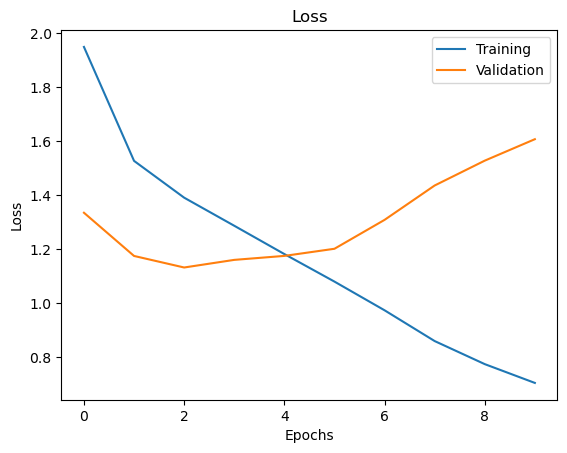

In [9]:
model.plot_loss()

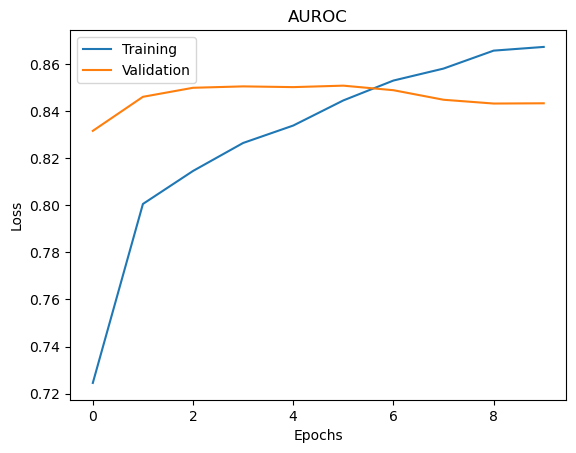

In [10]:
model.plot_auroc()

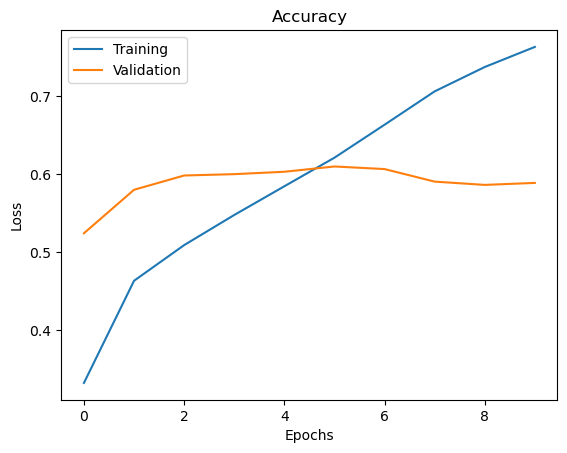

In [11]:
model.plot_accuracy()

In [13]:
torch.save(model, r"Unimodal Models\Finetuned_CvT_589.pth.tar")